# Reading MODIS data with xarray

## Import python packages

In [1]:
import pandas as pd
import s3fs
import xarray as xr

## Connect to bucket (anonymous login for public data only)

In [2]:
fs = s3fs.S3FileSystem(anon=True,
      client_kwargs={
         'endpoint_url': 'https://climate.uiogeo-apps.sigma2.no/'
      })

In [3]:
fs.ls('ESGF/obs4MIPs/MODIS/MODIS6.1terra')[:10]

['ESGF/obs4MIPs/MODIS/MODIS6.1terra/MakeAllYear.sh',
 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/MakeAllYear_Parallel.sh',
 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_clt_Column_2000_daily.nc',
 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_clt_Column_2001_daily.nc',
 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_clt_Column_2002_daily.nc',
 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_clt_Column_2003_daily.nc',
 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_clt_Column_2004_daily.nc',
 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_clt_Column_2005_daily.nc',
 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_clt_Column_2006_daily.nc',
 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_clt_Column_2007_daily.nc']

In [4]:
s3path = 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/*od550aer*.nc'
remote_files = fs.glob(s3path)
print(remote_files)

['ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2000_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2001_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2002_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2003_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2004_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2005_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2006_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2007_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2008_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2009_daily.nc', 'ESGF/obs4MIPs/MODIS/MODIS6.1terra/aerocom3_MODIS6.1terra_od550aer_Column_2010_daily.nc', 'ESGF/obs

## Access data files

In [5]:
# Iterate through remote_files to create a fileset
fileset = [fs.open(file) for file in remote_files]

## Data reading with xarray

In [6]:
# Read file with xarray
dset = xr.open_mfdataset(fileset, combine='by_coords')

In [7]:
dset

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, time: 6940)
Coordinates:
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2018-12-31
Data variables:
    od550aer   (time, latitude, longitude) float64 dask.array<chunksize=(366, 180, 360), meta=np.ndarray>
Attributes:
    HDFEOSVersion:                     HDFEOS_V2.17
    identifier_product_doi:            10.5067/MODIS/MOD08_D3.061
    identifier_product_doi_authority:  http://dx.doi.org
    history:                           Mon Dec  2 09:46:57 2019: ncks -4 -L 5...
    NCO:                               netCDF Operators version 4.7.8 (Homepa...

## Plot a single time

In [8]:
!pip install cmaps

In [9]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmaps

Text(0.5, 1.0, 'MODIS - 2001-01-01\n ')

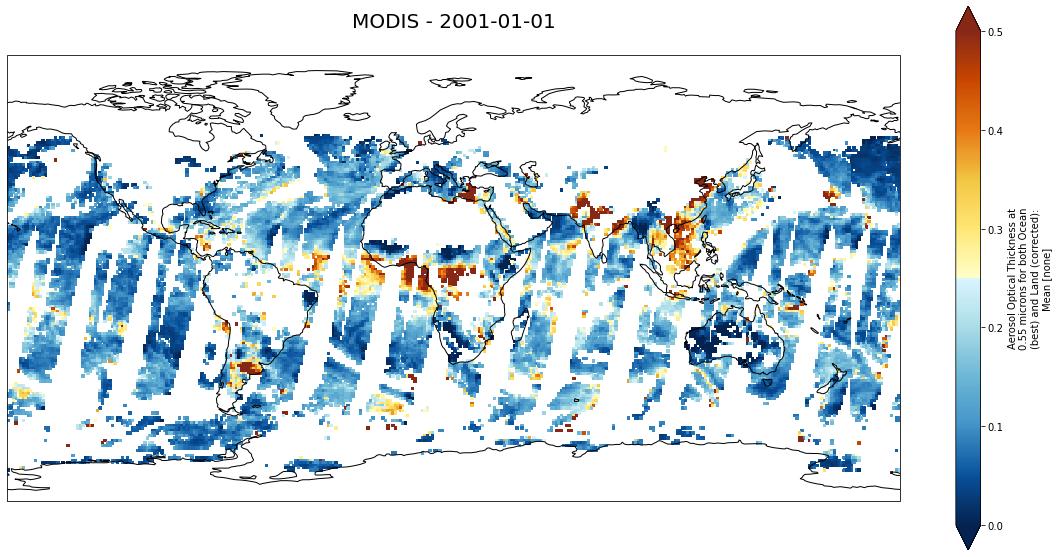

In [10]:
fig=plt.figure(figsize=(20,10))

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=20.0, globe=None))
ax.coastlines(resolution='110m')

# custom colormap
lcmap = cmaps.BlueYellowRed

# We need to project our data to the new Mercator projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
# we only plot values greather than 0
dset['od550aer'].sel(time='2001-01-01').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=lcmap, vmin=0., vmax=.5)
ax.set_title('MODIS - 2001-01-01\n ', fontsize=20)

## Interactive plot

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from datetime import datetime

In [12]:
def plot_map(date):
    fig=plt.figure(figsize=(20,10))

    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=20.0, globe=None))
    ax.coastlines(resolution='110m')

    # custom colormap
    lcmap = cmaps.BlueYellowRed

    # We need to project our data to the new Mercator projection and for this we use `transform`.
    # we set the original data projection in transform (here PlateCarree)
    # we only plot values greather than 0
    dset['od550aer'].sel(time=date).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=lcmap, vmin=0., vmax=.5)
    ax.set_title('MODIS - {}\n '.format(date), fontsize=20)

In [24]:
start_date = datetime(2000, 1, 1)
end_date = datetime(2018, 12, 31)

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime('%Y-%m-%d'), date) for date in dates]
index = (0, len(options)-1)

date_slider = widgets.SelectionSlider(
    options=options,
    orientation='horizontal',
    layout={'width': '800px'}
)

In [25]:
interact(plot_map, date=date_slider);

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('2000-01-01'…